In [1]:
%pip install -q datasetsforecast neuralforecast utilsforecast statsforecast

Note: you may need to restart the kernel to use updated packages.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Estimated FLOPs for KAN model: 25284.0


2024-11-15 02:45:06.182804: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 02:45:06.396141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731638706.461386    2149 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731638706.479189    2149 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 02:45:06.621952: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/neuralforecast/core.py:902: UserWarning: Dropped 358 unused rows from `futr_df`.
  warnings.warn(f"Dropped {dropped_rows:,} unused rows from `futr_df`.")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


Mean Squared Error (MSE) on Test Data: 1.4201


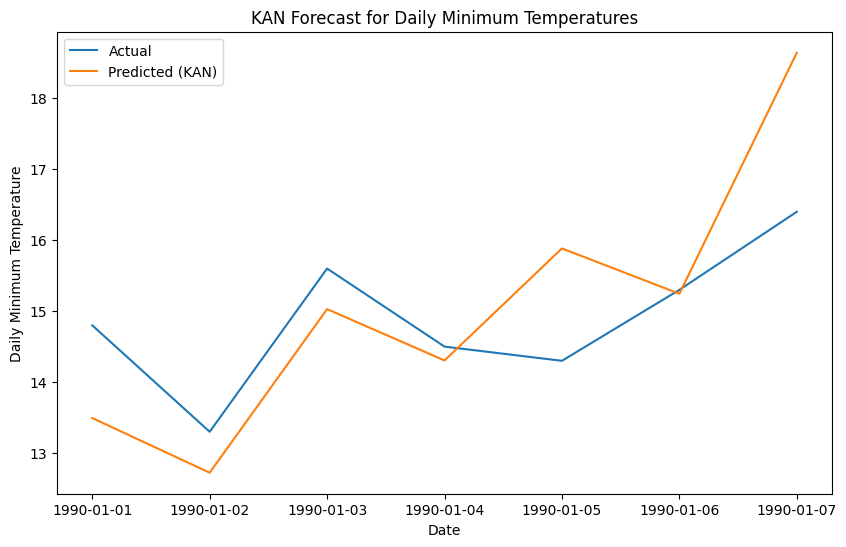

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import KAN
from sklearn.metrics import mean_squared_error

# Load the dataset
df = pd.read_csv("datasets/dailymintemp.csv")
df = df.rename(columns={"Date": "ds", "Daily minimum temperatures": "y"})
df["unique_id"] = "TempSeries"
df["ds"] = pd.to_datetime(df["ds"])

# Split into training and testing sets
train_df = df[df["ds"] < "1990-01-01"]
test_df = df[df["ds"] >= "1990-01-01"]

# Define forecast horizon
horizon = 7  # Predicting the next week

# Configure the KAN model
kan_model = KAN(
    h=horizon,
    input_size=2 * horizon,
    scaler_type='standard',
    max_steps=500,
    early_stop_patience_steps=3
)

# FLOPs Calculation Function
def calculate_kan_flops(din, dout, G, K):
    return (din * dout) * (9 * K * (G + 1.5 * K) + 2 * G - 2.5 * K - 1)

# Parameters for FLOP calculation
din = kan_model.input_size       # input size to KAN
dout = kan_model.h               # forecast horizon
grid_size = 5                    # Assumed grid size used in KAN
spline_order = 3                 # Assumed spline order for KAN
flops = calculate_kan_flops(din, dout, grid_size, spline_order)
print(f"Estimated FLOPs for KAN model: {flops}")

# Initialize NeuralForecast
nf = NeuralForecast(models=[kan_model], freq='D')

# Calculate validation size
val_size = int(0.1 * len(train_df))

# Train the model (pass val_size)
nf.fit(df=train_df, val_size=val_size)

# Generate predictions
neural_preds = nf.predict(futr_df=test_df[['unique_id', 'ds']])

# Merge predictions with actual data
results = pd.merge(test_df, neural_preds, on=['unique_id', 'ds'], how='left')

# Drop rows with NaNs in either 'y' or 'KAN' columns
results = results.dropna(subset=['y', 'KAN'])

# Calculate Mean Squared Error (MSE) for accuracy
mse = mean_squared_error(results['y'], results['KAN'])
print(f"Mean Squared Error (MSE) on Test Data: {mse:.4f}")


# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(results['ds'], results['y'], label='Actual')
plt.plot(results['ds'], results['KAN'], label='Predicted (KAN)')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Daily Minimum Temperature')
plt.title('KAN Forecast for Daily Minimum Temperatures')
plt.show()

/tmp/ipykernel_2188/4202935929.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


Estimated FLOPs for the MLP model: 24200
Epoch [100/500], Loss: 8.2382
Epoch [200/500], Loss: 8.1213
Epoch [300/500], Loss: 8.0416
Epoch [400/500], Loss: 8.0022
Epoch [500/500], Loss: 7.9568

Mean Squared Error (MSE) on Test Data: 7.0565


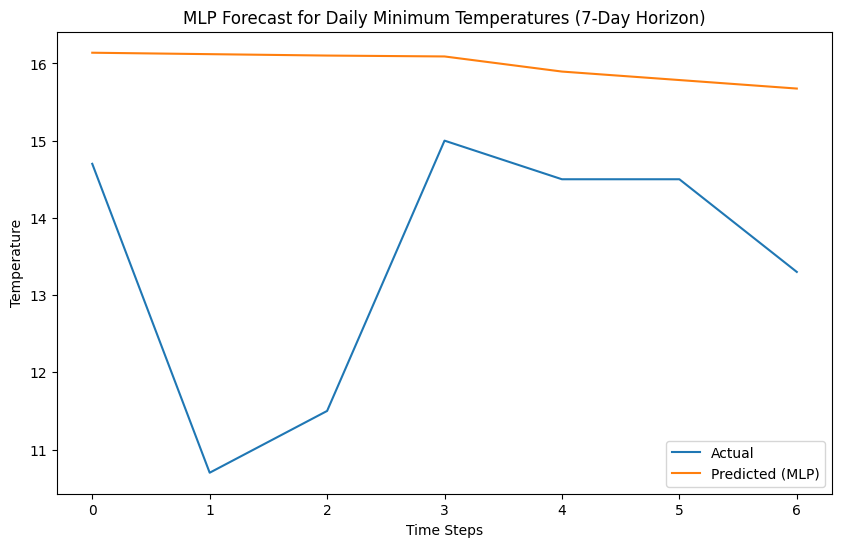

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("datasets/dailymintemp.csv")
df = df.rename(columns={"Date": "ds", "Daily minimum temperatures": "y"})
df["unique_id"] = "TempSeries"
df["ds"] = pd.to_datetime(df["ds"])

# Split into training and testing sets
train_df = df[df["ds"] < "1990-01-01"]
test_df = df[df["ds"] >= "1990-01-01"]

# Define forecast horizon
horizon = 7  # Predicting the next week

# Prepare data for MLP: Convert time series into a supervised learning format
def create_supervised_data(df, input_size, horizon):
    X, y = [], []
    for i in range(len(df) - input_size - horizon + 1):
        X.append(df['y'].iloc[i: i + input_size].values)
        y.append(df['y'].iloc[i + input_size: i + input_size + horizon].values)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Define input size (lags) based on horizon
input_size = 2 * horizon

# Prepare training and testing data
X_train, y_train = create_supervised_data(train_df, input_size, horizon)
X_test, y_test = create_supervised_data(test_df, input_size, horizon)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers=2):
        super(MLP, self).__init__()
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        
        # Hidden layers
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        
        # Output layer
        layers.append(nn.Linear(hidden_size, output_size))
        
        # Create the sequential model
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Initialize model parameters
input_size = X_train.shape[1]
hidden_size = 100
output_size = horizon

# Instantiate model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)

# Move data to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Calculate FLOPs for the MLP
def calculate_mlp_flops(model, input_size):
    flops = 0
    for layer in model.model:
        if isinstance(layer, nn.Linear):
            layer_flops = 2 * layer.in_features * layer.out_features
            flops += layer_flops
    return flops

flops = calculate_mlp_flops(model, input_size)
print(f"Estimated FLOPs for the MLP model: {flops}")

# Train the model
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train)
    loss = criterion(predictions, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Evaluate the model (Mean Squared Error)
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    mse = criterion(predictions, y_test).item()
    print(f"\nMean Squared Error (MSE) on Test Data: {mse:.4f}")

# Convert predictions to numpy for plotting
predictions_np = predictions.cpu().numpy().flatten()
y_test_np = y_test.cpu().numpy().flatten()

# Plot predictions vs actual values
# Plot predictions vs actual values for only the first 7 time steps
plt.figure(figsize=(10, 6))
plt.plot(range(7), y_test_np[:7], label='Actual')
plt.plot(range(7), predictions_np[:7], label='Predicted (MLP)')
plt.legend()
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.title('MLP Forecast for Daily Minimum Temperatures (7-Day Horizon)')
plt.show()

